In [0]:
import random as rn
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Progbar
from tensorflow import keras
from tensorflow.keras import initializers
from tensorflow import nn

In [0]:
# Defining random seeds
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)
rn.seed(random_seed)

In [0]:
# Loading data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

height = 28
width = 28
n_channel = 1

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape(x_train.shape[0], height, width, n_channel)
x_test = x_test.reshape(x_test.shape[0], height, width, n_channel)

In [0]:
def quantise(images, q_levels):
    """Quantise image into q levels"""
    return (np.digitize(images, np.arange(q_levels) / q_levels) - 1).astype('float32')

In [0]:
# Quantise the input data in q levels
q_levels = 2
x_train_quantised = quantise(x_train, q_levels)
x_test_quantised = quantise(x_test, q_levels)

In [0]:
# Creating input stream using tf.data API
batch_size = 128
train_buf = 60000

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_quantised / (q_levels - 1),
                                                    x_train_quantised.astype('int32')))
train_dataset = train_dataset.shuffle(buffer_size=train_buf)
train_dataset = train_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test_quantised / (q_levels - 1),
                                                   x_test_quantised.astype('int32')))
test_dataset = test_dataset.batch(batch_size)

In [0]:
class MaskedConv2D(keras.layers.Layer):
    """Convolutional layers with masks for Gated PixelCNN.

    Masked convolutional layers used to implement Vertical and Horizontal
    stacks of the Gated PixelCNN.

    Note: This implementation is different from the normal PixelCNN.

    Arguments:
    mask_type: one of `"V"`, `"A"` or `"B".`
    filters: Integer, the dimensionality of the output space
        (i.e. the number of output filters in the convolution).
    kernel_size: An integer or tuple/list of 2 integers, specifying the
        height and width of the 2D convolution window.
        Can be a single integer to specify the same value for
        all spatial dimensions.
    strides: An integer or tuple/list of 2 integers,
        specifying the strides of the convolution along the height and width.
        Can be a single integer to specify the same value for
        all spatial dimensions.
        Specifying any stride value != 1 is incompatible with specifying
        any `dilation_rate` value != 1.
    padding: one of `"valid"` or `"same"` (case-insensitive).
    kernel_initializer: Initializer for the `kernel` weights matrix.
    bias_initializer: Initializer for the bias vector.
    """

    def __init__(self,
                 mask_type,
                 filters,
                 kernel_size,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros'):
        super(MaskedConv2D, self).__init__()

        assert mask_type in {'A', 'B', 'V'}
        self.mask_type = mask_type

        self.filters = filters

        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        self.kernel_size = kernel_size

        self.strides = strides
        self.padding = padding.upper()
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

    def build(self, input_shape):
        kernel_h, kernel_w = self.kernel_size

        self.kernel = self.add_weight('kernel',
                                      shape=(kernel_h,
                                             kernel_w,
                                             int(input_shape[-1]),
                                             self.filters),
                                      initializer=self.kernel_initializer,
                                      trainable=True)

        self.bias = self.add_weight('bias',
                                    shape=(self.filters,),
                                    initializer=self.bias_initializer,
                                    trainable=True)

        mask = np.ones(self.kernel.shape, dtype=np.float32)

        if kernel_h % 2 != 0: 
            center_h = kernel_h // 2
        else:
            center_h = (kernel_h - 1) // 2

        if kernel_w % 2 != 0: 
            center_w = kernel_w // 2
        else:
            center_w = (kernel_w - 1) // 2

        if self.mask_type == 'V':
            mask[center_h + 1:, :, :, :] = 0.
        else:
            mask[:center_h, :, :] = 0.
            mask[center_h, center_w + (self.mask_type == 'B'):, :, :] = 0.
            mask[center_h + 1:, :, :] = 0.          

        self.mask = tf.constant(mask, dtype=tf.float32, name='mask')

    def call(self, input):
        masked_kernel = tf.math.multiply(self.mask, self.kernel)
        x = nn.conv2d(input,
                      masked_kernel,
                      strides=[1, self.strides, self.strides, 1],
                      padding=self.padding)
        x = nn.bias_add(x, self.bias)
        return x

In [0]:
class GatedBlock(tf.keras.Model):
    """ Gated block of the Gated PixelCNN."""

    def __init__(self, mask_type, filters, kernel_size):
        super(GatedBlock, self).__init__(name='')

        self.mask_type = mask_type
        self.vertical_conv = MaskedConv2D(mask_type='V',
                                          filters=2 * filters,
                                          kernel_size=kernel_size)
        
        self.horizontal_conv = MaskedConv2D(mask_type=mask_type,
                                            filters=2 * filters,
                                            kernel_size=kernel_size)

        self.padding = keras.layers.ZeroPadding2D(padding=((1,0),0))
        self.cropping = keras.layers.Cropping2D(cropping=((0, 1), 0))

        self.v_to_h_conv = keras.layers.Conv2D(filters=2 * filters, kernel_size=1)

        self.horizontal_output = keras.layers.Conv2D(filters=filters, kernel_size=1)

    def _gate(self, x):
        tanh_preactivation, sigmoid_preactivation = tf.split(x, 2, axis=-1)
        return tf.nn.tanh(tanh_preactivation) * tf.nn.sigmoid(sigmoid_preactivation)

    def call(self, input_tensor):
        v = input_tensor[0]
        h = input_tensor[1]

        vertical_preactivation = self.vertical_conv(v)  # NxN

        # Shifting feature map down to ensure causality
        v_to_h = self.padding(vertical_preactivation)
        v_to_h = self.cropping(v_to_h)
        v_to_h = self.v_to_h_conv(v_to_h)  # 1x1

        horizontal_preactivation = self.horizontal_conv(h)  # 1xN
        
        v_out = self._gate(vertical_preactivation)

        horizontal_preactivation = horizontal_preactivation + v_to_h
        h_activated = self._gate(horizontal_preactivation)
        h_activated = self.horizontal_output(h_activated)

        if self.mask_type == 'A':
            h_out = h_activated
        elif self.mask_type == 'B':
            h_out = h + h_activated

        return v_out, h_out

In [0]:
# Create Gated PixelCNN model
inputs = keras.layers.Input(shape=(height, width, n_channel))
v, h = GatedBlock(mask_type='A', filters=64, kernel_size=3)([inputs, inputs])

for i in range(7):
    v, h = GatedBlock(mask_type='B', filters=64, kernel_size=3)([v, h])

x = keras.layers.Activation(activation='relu')(h)
x = keras.layers.Conv2D(filters=128, kernel_size=1, strides=1)(x)

x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.Conv2D(filters=q_levels, kernel_size=1, strides=1)(x)

gated_pixelcnn = tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
# Prepare optimizer and loss function
lr_decay = 0.999995
learning_rate = 1e-3
optimizer = keras.optimizers.Adam(lr=learning_rate)

compute_loss = keras.losses.CategoricalCrossentropy(from_logits=True)

In [0]:
@tf.function
def train_step(batch_x, batch_y):
    with tf.GradientTape() as ae_tape:
        logits = gated_pixelcnn(batch_x, training=True)

        loss = compute_loss(tf.squeeze(tf.one_hot(batch_y, q_levels)), logits)

    gradients = ae_tape.gradient(loss, gated_pixelcnn.trainable_variables)
    gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
    optimizer.apply_gradients(zip(gradients, gated_pixelcnn.trainable_variables))

    return loss

In [12]:
# Training loop
n_epochs = 100
n_iter = int(np.ceil(x_train_quantised.shape[0] / batch_size))
for epoch in range(n_epochs):
    progbar = Progbar(n_iter)
    print('Epoch {:}/{:}'.format(epoch + 1, n_epochs))

    for i_iter, (batch_x, batch_y) in enumerate(train_dataset):
        optimizer.lr = optimizer.lr * lr_decay
        loss = train_step(batch_x, batch_y)

        progbar.add(1, values=[('loss', loss)])

Epoch 1/100
469/469 [==============================] - 176s 376ms/step - loss: 0.1096
Epoch 2/100
469/469 [==============================] - 171s 366ms/step - loss: 0.0892
Epoch 3/100
469/469 [==============================] - 171s 365ms/step - loss: 0.0864
Epoch 4/100
469/469 [==============================] - 171s 365ms/step - loss: 0.0848
Epoch 5/100
469/469 [==============================] - 171s 365ms/step - loss: 0.0837
Epoch 6/100
469/469 [==============================] - 171s 365ms/step - loss: 0.0829
Epoch 7/100
 92/469 [====>.........................] - ETA: 2:18 - loss: 0.0824

KeyboardInterrupt: ignored

In [13]:
# Test set performance
test_loss = []
for batch_x, batch_y in test_dataset:
    logits = gated_pixelcnn(batch_x, training=False)

    # Calculate cross-entropy (= negative log-likelihood)
    loss = compute_loss(tf.one_hot(batch_y, q_levels), logits)

    test_loss.append(loss)
print('nll : {:} nats'.format(np.array(test_loss).mean()))
print('bits/dim : {:}'.format(np.array(test_loss).mean() / np.log(2)))

nll : 0.08227105438709259 nats
bits/dim : 0.11869204217296468


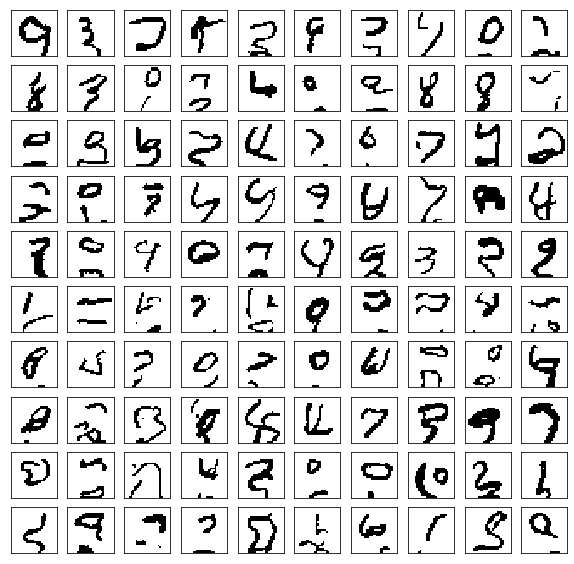

In [14]:
# Generating new images
samples = np.zeros((100, height, width, n_channel), dtype='float32')
for i in range(height):
    for j in range(width):
        logits = gated_pixelcnn(samples)
        next_sample = tf.random.categorical(logits[:, i, j, :], 1)
        samples[:, i, j, 0] = (next_sample.numpy() / (q_levels - 1))[:, 0]

fig = plt.figure(figsize=(10, 10))
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.matshow(samples[i, :, :, 0], cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()

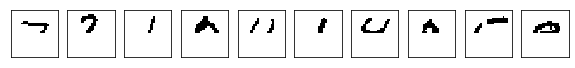

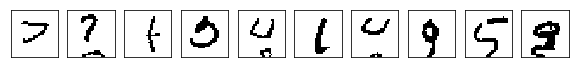

In [15]:
# Filling occluded images
occlude_start_row = 14
num_generated_images = 10
samples = np.copy(x_test_quantised[0:num_generated_images, :, :, :])
samples = samples / (q_levels - 1)
samples[:, occlude_start_row:, :, :] = 0

fig = plt.figure(figsize=(10, 10))

for i in range(10):
    ax = fig.add_subplot(1, 10, i + 1)
    ax.matshow(samples[i, :, :, 0], cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))

for i in range(occlude_start_row, height):
    for j in range(width):
        logits = gated_pixelcnn(samples)
        next_sample = tf.random.categorical(logits[:, i, j, :], 1)
        samples[:, i, j, 0] = (next_sample.numpy() / (q_levels - 1))[:, 0]

fig = plt.figure(figsize=(10, 10))

for i in range(10):
    ax = fig.add_subplot(1, 10, i + 1)
    ax.matshow(samples[i, :, :, 0], cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()